In [10]:
##kernelが止まるようなエラーがでる場合
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'



In [11]:

import pandas as pd
import numpy as np
from keras.preprocessing.image import load_img, img_to_array

gsdata = pd.read_csv("./trainingdata.csv")

gsdata.columns


Index(['filenames', 'abnormal'], dtype='object')

In [12]:
trainingImgData = np.zeros((len(gsdata["filenames"]), 128, 128, 1))
for i in range(0, len(gsdata["filenames"])):
    fnametmp = './JPGs/%s' %gsdata["filenames"][i]
    trainingImgData[i] = np.array(img_to_array(load_img(fnametmp, grayscale=True, target_size=(128,128))))/255.0
trainingImgData.shape


(342, 128, 128, 1)

In [13]:
trainingGSData = np.zeros((len(gsdata["abnormal"]),  1), dtype='int')
for i in range(0, len(gsdata["filenames"])):
   trainingGSData[i][0]=gsdata["abnormal"][i]
trainingGS = trainingGSData.copy()
from tensorflow.python.keras.utils import to_categorical
onehotlabel_train = to_categorical(trainingGS, 2)


In [14]:
print(trainingImgData.shape)
print(trainingGSData.shape)
print(onehotlabel_train.shape)

(342, 128, 128, 1)
(342, 1)
(342, 2)


In [15]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D
from tensorflow.python.keras.layers import MaxPooling2D
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Dense
model = Sequential()
model.add(
    Conv2D(
        filters = 32,
        input_shape=(128, 128, 1),
        kernel_size=(3, 3),
        strides=(1, 1),
        padding='same',
        activation='relu'
    )
)

model.add(
    Conv2D(
        filters = 32,
        kernel_size = (3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu'
    )
)

#プーリング層とドロップアウトの設定（１）
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))


#畳み込み層の追加（２）
model.add(
    Conv2D(
        filters = 64,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding='same',
        activation='relu'
    )
)

model.add(
    Conv2D(
        filters = 64,
        kernel_size = (3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu'
    )
)
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units= 2, activation='softmax'))



In [16]:
model.compile(
	loss='binary_crossentropy', 
	optimizer='adam', 
	metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
__________

In [17]:
hist = model.fit(trainingImgData, onehotlabel_train,
                batch_size=8, 
                epochs=50, 
                validation_split=0.2, 
                verbose=1)


Train on 273 samples, validate on 69 samples
Epoch 1/50
273/273 [==============================] - 21s 79ms/step - loss: 0.6800 - acc: 0.6190 - val_loss: 0.1739 - val_acc: 1.0000
Epoch 2/50
273/273 [==============================] - 1s 4ms/step - loss: 0.3445 - acc: 0.8388 - val_loss: 0.0446 - val_acc: 1.0000
Epoch 3/50
273/273 [==============================] - 1s 4ms/step - loss: 0.1675 - acc: 0.9487 - val_loss: 0.0162 - val_acc: 1.0000
Epoch 4/50
273/273 [==============================] - 1s 4ms/step - loss: 0.1646 - acc: 0.9414 - val_loss: 0.3338 - val_acc: 0.7971
Epoch 5/50
273/273 [==============================] - 1s 5ms/step - loss: 0.1341 - acc: 0.9414 - val_loss: 5.7877e-04 - val_acc: 1.0000
Epoch 6/50
273/273 [==============================] - 1s 4ms/step - loss: 0.0304 - acc: 0.9927 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 7/50
273/273 [==============================] - 1s 5ms/step - loss: 0.0573 - acc: 0.9927 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 8/50
273/273 [=====

In [18]:
from keras.models import load_model
model.save('myCNNClassificationMirror.h5')

In [19]:
resubgender = model.predict(trainingImgData, verbose=1)
from sklearn.metrics import accuracy_score, confusion_matrix
results = list(model.predict_classes(trainingImgData, verbose=1))
score = accuracy_score(trainingGS, results)
print(score)
cmatrix = confusion_matrix(trainingGS, results)
print(cmatrix)


342/342 [==============================] - 0s 679us/step
1.0
[[193   0]
 [  0 149]]


In [20]:
resubgender.shape
resubgender[:,1]
trainingGS = trainingGS.copy()
trainingGS = np.ravel(trainingGS)

In [21]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics
import matplotlib.pyplot as plt
fpf, tpf, thresholds = metrics.roc_curve(trainingGS, resubgender[:,1])

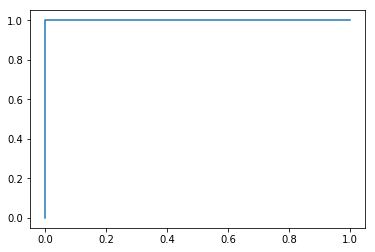

In [22]:
import matplotlib.pyplot as plt
plt.plot(fpf, tpf)

In [23]:
roc_auc_score(trainingGS, resubgender[:,1])

1.0

C:\Users\ipteca16\Anaconda3\envs\dls\lib\site-packages\keras_preprocessing\image\utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


1.0


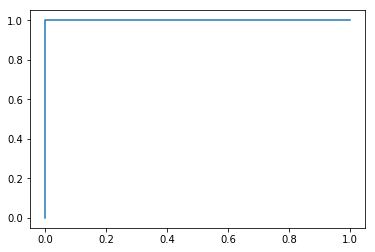

In [31]:
testdata = pd.read_csv("./testdata.csv")
testImgData = np.zeros((len(testdata["filenames"]), 128, 128, 1))

for i in range(0, len(testdata["filenames"])):
    fnametmp = './JPGs/%s' %testdata["filenames"][i]
    testImgData[i] = np.array(img_to_array(load_img(fnametmp, grayscale=True, target_size=(128,128))))/255.0
testGSData = np.zeros((len(testdata["abnormal"]),  1), dtype='int')
for i in range(0, len(testdata["filenames"])):
   testGSData[i][0]=testdata["abnormal"][i]
testGS = testGSData.copy()
testGS = np.ravel(testGS)
valigender = model.predict(testImgData)
fpf, tpf, thresholds = metrics.roc_curve(testGS, valigender[:,1])
plt.plot(fpf, tpf)

print(roc_auc_score(testGS, valigender[:,1]))

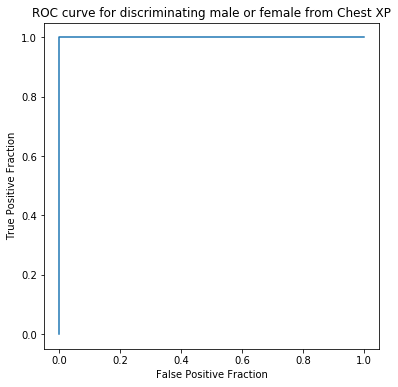

AUC = 1.0


In [26]:
plt.figure(figsize=(6,6))
plt.plot(fpf, tpf)
plt.xlabel("False Positive Fraction")
plt.ylabel("True Positive Fraction")
plt.title("ROC curve for discriminating male or female from Chest XP")
plt.show()
auc =roc_auc_score(testGS, valigender[:,1])
print('AUC =', round(auc, 3))

In [27]:
len(testGS)

25